In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from forex.pre_training_data_prep.config import config
from forex.pre_training_data_prep.DataPrepTimeseries import DataPrepTimeseries

In [3]:
filename_train_val_test_dict = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output/n_back_equals_180/dict_final_numpy.pickled'

In [4]:
ts = DataPrepTimeseries(filename_train_val_test_dict, config, stat_function = np.mean)

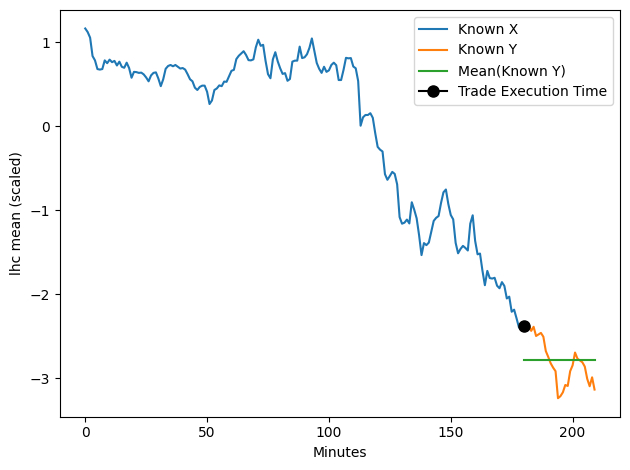

In [5]:
ts.plot_it(index_panel = 2000)

In [ ]:
import pickle
import json
import pprint as pp
import numpy as np

from tensorflow.keras.models import model_from_json

#from plotting_utilities import plot_basic_loss
# instead
import matplotlib.pyplot as plt

In [ ]:
application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output'

In [ ]:
#training_run = 'blah----9101c2e0-43cb-4a70-9aff-8680f73edf62'
training_run = 'blah----d2707bf6-0b59-44ae-acaf-bfbe32276743'  # mean, three hours back


In [ ]:
class ModelResult():
    def __init__(
        self,
        model_training_output_directory,
        training_run,
        timeseries,
        feature_name = 'lhc_mean',
    ):
        self.model_training_output_directory = model_training_output_directory
        self.training_run = training_run
        self.filename_history = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'
        self.filename_config_json = model_training_output_directory + '/' + training_run + '_lstm_regressor_config.json'
        self.filename_model_json = model_training_output_directory + '/' + training_run + '_model_regressor.json'
        self.filename_model_final_weights = model_training_output_directory + '/' + training_run + '_final_weights_regressor.pickled'
        self.train_val_test_data = timeseries
        self.feature_name = feature_name

    def fit(self):
        self.load_model()
        self.load_training_run_config()
        self.load_training_history()
        self.predict()
        self.compute_error()
    
    def load_model(self):
        with open(self.filename_model_json, 'r') as json_file:
            loaded_model_json = json_file.read()

        # Create a new model from the JSON
        self.model = model_from_json(loaded_model_json)

        # Load the weights into the new model
        self.model.load_weights(self.filename_model_final_weights)

    def load_training_history(self):
        try:
            with open(self.filename_history, 'rb') as ff:
                self.history = pickle.load(ff)
        except Exception as exception:
            print(exception)
            sys.exit(-1)
        
    def load_training_run_config(self):
        with open(self.filename_config_json) as ff:
            self.config = json.load(ff)

    def print_training_run_config(self):
        pp.pprint(self.config)
    
    def print_model_summary(self):
        self.model.summary()

    #
    # Define a function for plotting loss/mse against
    # validation loss/mse per training epoch
    #
    def plot_basic_loss(self, metric_base = 'loss', ylabel = 'Loss'):
        epochs = range(1, len(self.history[metric_base]) + 1)

        plt.figure()
        plt.plot(epochs, self.history[metric_base], '-.', label = ylabel)
        plt.plot(epochs, self.history['val_' + metric_base], '-.', label = 'Validation ' + ylabel)
        plt.xlabel('Training Epoch')
    
        plt.ylabel(ylabel)
        plt.title('Training Run: ' + self.training_run.split('----')[-1] + '\nBatch Size = ' + str(self.config['batch_size']))
    
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    def predict(self, set_name = 'test'):
        X_to_predict_y_response_for = ts.matrices[set_name]['X']
        self.y_predicted = self.model.predict(X_to_predict_y_response_for)

    
    def compute_error(self, feature_name = 'lhc_mean', set_name = 'test'):
        ts = self.train_val_test_data
        feature_index = ts.features_name_to_index[feature_name]
        y_known = ts.matrices[set_name]['y'][:, :, feature_index]

        if self.y_predicted.shape[1] == 1:
            y_predicted = self.y_predicted
            y_known = np.expand_dims(ts.y_stat_dict[set_name][:, feature_index], axis = 1)
            
            self.error_metric = (np.sum((y_known - y_predicted) ** 2)) / y_predicted.shape[0]
            self.error_metric_per_sample = ((y_known - y_predicted) ** 2) / y_predicted.shape[0]
        
        elif self.y_predicted.shape[1] == ts.config['n_forward']:
            pass  # implement this later
        else:
            pass # send an error message or something, or create code to work with this possibility

    
    def plot_error_histogram(
        self,
        n_bins = 30,
        color = 'lightblue',
        error_metric_name = 'Squared Error',
        cut_percentile = 75,
    ):

        if self.y_predicted.shape[1] == 1:
            data_for_boxplot = self.error_metric_per_sample                

        elif self.y_predicted.shape[1] == ts.config['n_forward']:
            pass # do something with this later
        else:
            pass # do something with this later

        data_for_boxplot_mean = np.mean(data_for_boxplot)
        data_for_boxplot_median = np.median(data_for_boxplot)
        
        data_for_boxplot_cut_percentile = np.percentile(data_for_boxplot, cut_percentile)
        data_for_boxplot_cut_top = data_for_boxplot[data_for_boxplot <= data_for_boxplot_cut_percentile]

        plt.figure(figsize = [9, 4])
        
        plt.subplot(1, 2, 1)
        plt.hist(data_for_boxplot, bins = n_bins, color = color)
        plt.axvline(data_for_boxplot_mean, label = 'Mean')
        plt.axvline(data_for_boxplot_median, label = 'Median')
        plt.xlabel(error_metric_name)
        plt.ylabel('Count')
        plt.title('Error Distribution (Full Results)')

        plt.subplot(1, 2, 2)
        plt.hist(data_for_boxplot_cut_top, bins = n_bins, color = color)
        plt.axvline(data_for_boxplot_mean, color = 'blue', label = 'Mean (of Full 100% of Data)')
        plt.axvline(data_for_boxplot_median, color = 'magenta', label = 'Median (of Full 100% of Data')
        plt.xlabel(error_metric_name)
        plt.ylabel('Count')
        plt.title('Error Distribution (0 to ' + str(cut_percentile) + 'th Percentile of Results)')

        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()
    
    def plot_a_prediction(
        self,
        index_panel = 0,
        feature_name = 'lhc_mean',
    ):

        self.train_val_test_data.plot_it(
            index_panel = index_panel,
            feature_name = 'lhc_mean',
            y_predicted = self.y_predicted[index_panel],
        )

In [ ]:
model_result = ModelResult(model_training_output_directory, training_run, ts)
model_result.fit()

In [ ]:
model_result.error_metric_per_sample

In [ ]:
model_result.plot_error_histogram()

In [ ]:
model_result.plot_basic_loss()

In [ ]:
#model_result.plot_error_histogram()

In [ ]:
model_result.plot_a_prediction(index_panel = 1700)

In [ ]:
def summary(model_result):
    mr = model_result
    
    ts = mr.train_val_test_data

    mr.summary_dict = {
        'training_run' : mr.training_run,
        'error_metric' : mr.error_metric,

        'config_source_data' : ts.config,
    }

In [ ]:
summary(model_result)
pp.pprint(model_result.summary_dict)

In [ ]:
from config_lstm_regressor import config as config_lstm_regressor
pp.pprint(config_lstm_regressor)